In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from sklearn.metrics import f1_score

import tensorflow as tf



In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def normalize_data(data):
    # Data pre-processing, Normalize each image with itself
    n = data.shape[0]
    for i in range(n):
        xx = data[i]
        xx -= np.mean(xx) # Centering in 0
        #xx /= np.linalg.norm(xx) # Normalizing to 1
        data[i] = xx # Affect value
    return data
def one_hot_convert(vector, num_classes=None):
    """ (From https://stackoverflow.com/questions/29831489/numpy-1-hot-array)
    Converts an input 1-D vector of integers into an output
    2-D array of one-hot vectors, where an i'th input value
    of j will set a '1' in the i'th row, j'th column of the
    output array.

    Example:
        v = np.array((1, 0, 4))
        one_hot_v = convertToOneHot(v)
        print one_hot_v

        [[0 1 0 0 0]
         [1 0 0 0 0]
         [0 0 0 0 1]]
    """

    assert isinstance(vector, np.ndarray)
    assert len(vector) > 0

    if num_classes is None:
        num_classes = np.max(vector)+1
    else:
        assert num_classes > 0
        assert num_classes >= np.max(vector)

    result = np.zeros(shape=(len(vector), num_classes))
    result[np.arange(len(vector)), vector] = 1
    return result

def get_patches_all(x_data, y_label=None, patch_size=16):
    # Ccompute final siz of array of patches
    n_patch_h = x_data.shape[1] // patch_size
    n_patch_w = x_data.shape[2] // patch_size
    x_patches = np.zeros((x_data.shape[0]*n_patch_h*n_patch_w, patch_size, patch_size) + x_data.shape[3:])
    y_patches = np.zeros((x_data.shape[0]*n_patch_h*n_patch_w, patch_size, patch_size))
    
    # Iterate over all images to convert them to patches
    for i in range(x_data.shape[0]):
        y_temp = None
        if y_label is not None:
            y_temp = y_label[i]
        x_patches[i*(n_patch_h*n_patch_w):(i+1)*(n_patch_h*n_patch_w)], \
        y_patches[i*(n_patch_h*n_patch_w):(i+1)*(n_patch_h*n_patch_w)] = get_patches(x_data[i], y_temp, patch_size)
        
    # Compute label for gt (Each patch is either road or background)
    y_batch_label = get_patches_label(y_patches)
    return x_patches, y_patches, y_batch_label

def get_patches(x_data, y_label=None, patch_size=16):
    # Check if dimension are ok (x_data shapes are mulitples of patch)
    assert(x_data.shape[0] % patch_size == 0 and x_data.shape[1] % patch_size == 0)
    # Create new array that will contain all the patches
    n_patch_h = x_data.shape[0] // patch_size
    n_patch_w = x_data.shape[1] // patch_size
    x_patches = np.zeros((n_patch_h, n_patch_w, patch_size, patch_size) + x_data.shape[2:])
    y_patches = np.zeros((n_patch_h, n_patch_w, patch_size, patch_size))
    # Iterate over all batches
    for i in range(n_patch_h):
        for j in range(n_patch_w):
            x_patches[i, j] = x_data[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            if y_label is not None:
                y_patches[i, j] = y_label[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
    # Reshape tu have first dimension as linear feature instead of n_patch_h X n_patch_w
    x_patches = np.reshape(x_patches, (-1, patch_size, patch_size) + x_data.shape[2:])
    y_patches = np.reshape(y_patches, (-1, patch_size, patch_size))
    return x_patches, y_patches

def get_patches_label(y_batch):
    # Create vector of one and zeros (1 is road, 0 is background)
    y_label_unique = np.zeros((y_batch.shape[0]))
    # Take mean value of pixel to estiamte road yes or not
    for i in range(y_batch.shape[0]):
        y_label_unique[i] = np.around(np.mean(y_batch[i]))
    return y_label_unique

def get_useful_patches(patch_x, patch_y, min_threshold, max_threshold):
    """ From an array of [Num_patches x H x W x Num_channels] and its associated pixelwise labels,
    return patches with label mean > threshold"""

    first_patch=True
    for i in range(patch_x.shape[0]):
        if np.mean(patch_y[i])>min_threshold and np.mean(patch_y[i])<max_threshold:
            if first_patch:
                useful_patches_x =  np.expand_dims(patch_x[i], axis=0)
                useful_patches_y = np.expand_dims(patch_y[i],axis=0)
                first_patch=False
            else:
                useful_patches_x = np.append(useful_patches_x, np.expand_dims(patch_x[i],axis=0), axis=0)
                useful_patches_y = np.append(useful_patches_y, np.expand_dims(patch_y[i], axis=0), axis=0)

    return useful_patches_x, useful_patches_y

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
#n = min(20, len(files)) # Load maximum 20 images
n = len(files)
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = int(len(files)*0.5) 
#n=10 # Only use 10 images for training
print(np.max(imgs))
np_imgs = normalize_data(np.asarray(imgs))
train_imgs = np_imgs[:n]
val_imgs = np_imgs[n:]
np_gt = np.ceil(np.asarray(gt_imgs))
train_gt = np_gt[:n]
val_gt = np_gt[n:]
train_size = train_gt.shape[0]
val_size = val_gt.shape[0]

patch_size= 40

patch_tr, lab_tr,_ = get_patches_all(train_imgs, train_gt, patch_size)
patch_val, lab_val,_ = get_patches_all(val_imgs, val_gt, patch_size)

print(patch_tr.shape)
print(lab_tr.shape)

useful_patches_tr, useful_lab_tr = get_useful_patches(patch_tr, lab_tr, 0.3, 0.7)
useful_patches_val, useful_lab_val = get_useful_patches(patch_val, lab_val, 0.3, 0.7)
useful_lab_tr = useful_lab_tr.astype(int)
useful_lab_val = useful_lab_val.astype(int)

print(useful_patches_val.shape)

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png
1.0
(5000, 40, 40, 3)
(5000, 40, 40)
(1043, 40, 40, 3)


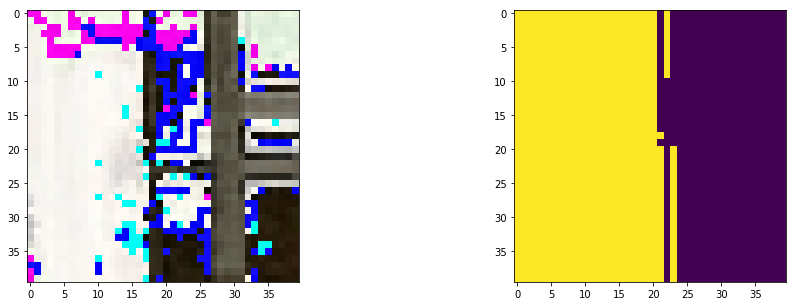

In [4]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.imshow(useful_patches_tr[1])
plt.subplot(1,2,2)
plt.imshow(useful_lab_tr[1])

In [5]:
def weighted_pixelwise_crossentropy(y_true, y_pred, class_weights):
    """computes pixelwise crossentropy"""
    temp = tf.clip_by_value(y_pred, 1e-8, 1. - 1e-8)
    loss = - tf.reduce_mean(tf.multiply(y_true * tf.log(temp), class_weights))
    return loss

In [6]:
learning_rate = 1e-4
reg = 1e-5
n_filters = 32
kernel_size = 3

#tf_data = tf.placeholder(tf.float32,[None, 400,400,3])
tf_data = tf.placeholder(tf.float32,[None, None, None, 3])
tf_labels = tf.placeholder(tf.int32,[None,2])
keep_prob = tf.placeholder(tf.float32)
regularizer = tf.contrib.layers.l2_regularizer(scale=reg)

class_weights = tf.constant([[2.0,1.0]]) #left = more BG, right = more road in predictions
weights = tf.reduce_sum(class_weights * tf.cast(tf_labels, tf.float32), axis=1)

conv1 = tf.layers.conv2d(inputs=tf_data, filters=n_filters, kernel_size=kernel_size, kernel_regularizer=regularizer, activation=tf.nn.relu, padding='SAME')
print("conv1 size", conv1.shape)

pool1 = tf.contrib.layers.max_pool2d(inputs=conv1, kernel_size=2, stride=2)
print("pool1 size", pool1.shape)

conv2 = tf.layers.conv2d(inputs=pool1, filters=n_filters, kernel_size=kernel_size, kernel_regularizer=regularizer, activation=tf.nn.relu, padding='SAME')
print("conv2 size", conv2.shape)

pool2 = tf.contrib.layers.max_pool2d(inputs=conv2, kernel_size=2, stride=2)
print("pool2 size", pool2.shape)

deconv1 = tf.layers.conv2d_transpose(inputs=pool2, filters=n_filters, kernel_size=4, strides=2, kernel_regularizer=regularizer, activation=tf.nn.relu, padding='SAME')
print("deconv1 size", deconv1.shape)

deconv2 = tf.layers.conv2d_transpose(inputs=deconv1, filters=n_filters, kernel_size=4, strides=2, kernel_regularizer=regularizer, activation=tf.nn.relu, padding='SAME')
print("deconv2 size", deconv2.shape)

score_layer = tf.layers.conv2d(inputs=deconv2, filters=2, kernel_size=1,kernel_regularizer=regularizer)
print("score size", score_layer.shape)

logits = tf.reshape(score_layer, (-1,2))

#trn_labels=tf.reshape(tf_labels, [-1])

#cross_entropy=tf.nn.softmax_cross_entropy_with_logits(logits,trn_labels,name='x_ent')
#loss=tf.reduce_mean(cross_entropy, name='x_ent_mean')
#train_op=tf.train.AdamOptimizer(FLAGS.learning_rate).minimize(loss,global_step=global_step)

#cross_entropy = weighted_pixelwise_crossentropy(tf.cast(tf_labels, dtype=tf.float32), logits, class_weights)
cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels=tf_labels, logits=logits, weights=weights)
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)
loss = reg_term + cross_entropy

train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

preds = tf.argmax(logits,axis=1,output_type=tf.int32)
print(logits.shape)
#preds= tf.argmax(tf.reshape(tf.nn.softmax(logits), (-1,400,400,2)), axis=3)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.cast(preds, tf.int32), tf.argmax(tf_labels, axis=1, output_type=tf.int32)), tf.float32))
#accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.reshape(preds, [-1]), tf.int32), tf.argmax(tf_labels,axis=1, output_type=tf.int32)), tf.float32))

conv1 size (?, ?, ?, 32)
pool1 size (?, ?, ?, 32)
conv2 size (?, ?, ?, 32)
pool2 size (?, ?, ?, 32)
deconv1 size (?, ?, ?, 32)
deconv2 size (?, ?, ?, 32)
score size (?, ?, ?, 2)
(?, 2)


In [7]:
##Model inference

n_epoch = 20
batch_size = 5

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for epoch in range(n_epoch):
    indices = np.random.permutation(useful_lab_tr.shape[0])

    for batch_iter in range(int(np.ceil(useful_lab_tr.shape[0]/batch_size))):
        
        batch_idx = indices[batch_iter*batch_size:min((batch_iter+1)*batch_size, indices.shape[0])]
        batch_x = useful_patches_tr[batch_idx]
        batch_y = one_hot_convert(np.reshape(useful_lab_tr[batch_idx], [-1]))
        #batch_x = np.expand_dims(cur_img,axis=0)
        #batch_y = one_hot_convert(np.reshape(train_gt[idx],(400*400)).astype(int),2)
        #batch_y = np.reshape(train_gt[idx],(400*400)).astype(int)
        

        _, train_acc, train_loss, train_cross_entropy, train_reg_term = sess.run([train_step, accuracy, loss, cross_entropy, reg_term], feed_dict={tf_data : batch_x, tf_labels : batch_y})

    if epoch % 1 ==0:
        print("last minibatch: ")
        print("cross entropy : ", train_cross_entropy)
        print("reg term : ", train_reg_term)
        train_pred, train_acc, train_loss = sess.run([preds, accuracy, loss], feed_dict={tf_data : train_imgs, tf_labels : one_hot_convert(np.reshape(train_gt,train_size*400*400).astype(int),2)})
        val_pred, val_acc, val_loss = sess.run([preds, accuracy, loss], feed_dict={tf_data : val_imgs, tf_labels : one_hot_convert(np.reshape(val_gt,val_size*400*400).astype(int),2)})
        
        print(max(np.reshape(train_pred, [-1])), min(np.reshape(train_pred, [-1])))
        print("val mean : ",np.mean(val_pred))
        print("train mean : ", np.mean(train_pred))

        f1_train = f1_score(np.reshape(train_gt,train_size*400*400), np.reshape(train_pred, [-1]), average='macro') 
        f1_val = f1_score(np.reshape(val_gt,val_size*400*400), np.reshape(val_pred,[-1]), average='macro')
        print("epoch ", epoch+1,", val f1 : ", f1_val, ", train f1 : ", f1_train)
        print("val_loss : ", val_loss, ", train_loss : ", train_loss)
        


last minibatch: 
cross entropy :  0.818041
reg term :  4.16546e-13
0 0
val mean :  0.0
train mean :  0.0


C:\Users\Gaet_2\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


epoch  1 , val f1 :  0.43310605374 , train f1 :  0.439927106513
val_loss :  0.760448 , train_loss :  0.742843
last minibatch: 
cross entropy :  0.918931
reg term :  4.32855e-13
0 0
val mean :  0.0
train mean :  0.0
epoch  2 , val f1 :  0.43310605374 , train f1 :  0.439927106513
val_loss :  0.795104 , train_loss :  0.779859
last minibatch: 
cross entropy :  0.853459
reg term :  4.57089e-13
1 0
val mean :  0.001502125
train mean :  0.001216875
epoch  3 , val f1 :  0.437801484291 , train f1 :  0.442914592546
val_loss :  0.778854 , train_loss :  0.760935
last minibatch: 
cross entropy :  0.915719
reg term :  4.86105e-13
1 0
val mean :  0.0156945
train mean :  0.014969
epoch  4 , val f1 :  0.473876385259 , train f1 :  0.480517530865
val_loss :  0.746929 , train_loss :  0.7247
last minibatch: 
cross entropy :  0.892172
reg term :  5.13767e-13
1 0
val mean :  0.053864875
train mean :  0.051578875
epoch  5 , val f1 :  0.542300818328 , train f1 :  0.546096815844
val_loss :  0.77071 , train_loss

1.0 0.0
0.236002
(400, 400)
float32


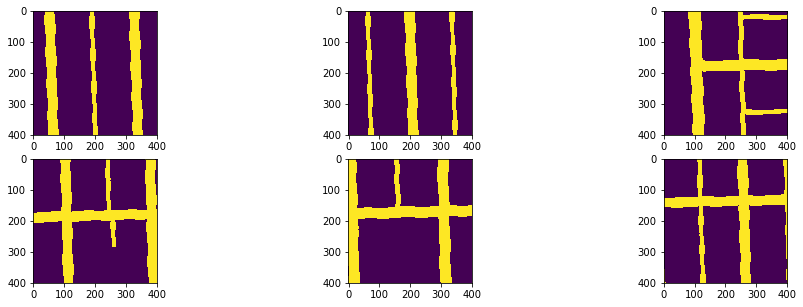

In [8]:
print(max(np.reshape(val_gt[1,:], [-1])),(min(np.reshape(val_gt[1,:], [-1]))))
print(np.mean(val_gt))
print(val_gt[1,:].shape)
print(val_gt.dtype)
plt.figure(figsize=(16, 5))
plt.subplot(2,3,1)
plt.imshow(val_gt[1,:])
plt.subplot(2,3,2)
plt.imshow(val_gt[2,:])
plt.subplot(2,3,3)
plt.imshow(val_gt[3,:])
plt.subplot(2,3,4)
plt.imshow(train_gt[1,:])
plt.subplot(2,3,5)
plt.imshow(train_gt[2,:])
plt.subplot(2,3,6)
plt.imshow(train_gt[3,:])

1.0 0.0
0.24269475
(400, 400)
float32


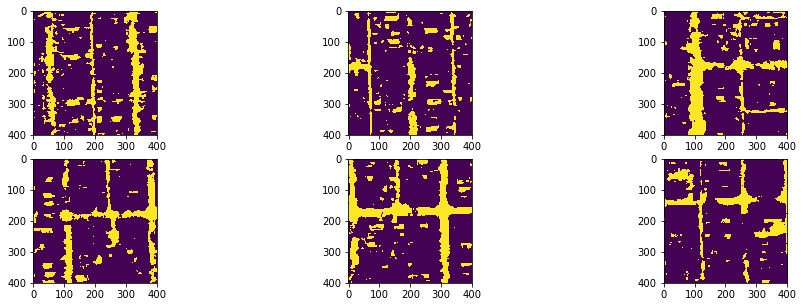

In [9]:
test = np.reshape(val_pred, val_gt.shape).astype(np.float32)
test2 = np.reshape(train_pred, train_gt.shape).astype(np.float32)

print(max(np.reshape(test[1,:], [-1])),(min(np.reshape(test[1,:], [-1]))))
print(np.mean(val_pred))
print(test[1,:].shape)
print(test.dtype)
plt.figure(figsize=(16, 5))
plt.subplot(2,3,1)
plt.imshow(test[1,:])
plt.subplot(2,3,2)
plt.imshow(test[2,:])
plt.subplot(2,3,3)
plt.imshow(test[3,:])
plt.subplot(2,3,4)
plt.imshow(test2[1,:])
plt.subplot(2,3,5)
plt.imshow(test2[2,:])
plt.subplot(2,3,6)
plt.imshow(test2[3,:])

0.882329 0.0
0.882329 0.0
1.511 0.0
1.511 0.0
1.8151 0.0
1.42466 0.0
2.66188 -4.08655


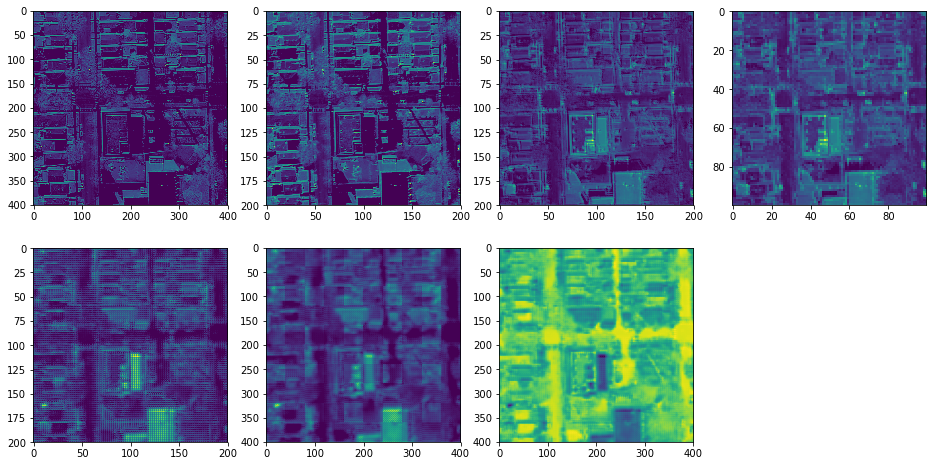

In [10]:
conv_1, pool_1, conv_2, pool_2, deconv_1, deconv_2, score= sess.run([conv1, pool1, conv2, pool2, deconv1, deconv2, score_layer], feed_dict={tf_data : np.expand_dims(train_imgs[1], axis=0), tf_labels : one_hot_convert(np.reshape(train_gt[1],400*400).astype(int),2)})

print(max(np.reshape(conv_1, [-1])), min(np.reshape(conv_1, [-1])))
print(max(np.reshape(pool_1, [-1])), min(np.reshape(pool_1, [-1])))
print(max(np.reshape(conv_2, [-1])), min(np.reshape(conv_2, [-1])))
print(max(np.reshape(pool_2, [-1])), min(np.reshape(pool_2, [-1])))
print(max(np.reshape(deconv_1, [-1])), min(np.reshape(deconv_1, [-1])))
print(max(np.reshape(deconv_2, [-1])), min(np.reshape(deconv_2, [-1])))
print(max(np.reshape(score, [-1])), min(np.reshape(score, [-1])))

plt.figure(figsize=(16,8))
plt.subplot(2,4,1)
plt.imshow((np.asarray(np.squeeze(conv_1)[:,:,1])))
plt.subplot(2,4,2)
plt.imshow((np.asarray(np.squeeze(pool_1)[:,:,1])))
plt.subplot(2,4,3)
plt.imshow((np.asarray(np.squeeze(conv_2)[:,:,1])))
plt.subplot(2,4,4)
plt.imshow((np.asarray(np.squeeze(pool_2)[:,:,1])))
plt.subplot(2,4,5)
plt.imshow((np.asarray(np.squeeze(deconv_1)[:,:,1])))
plt.subplot(2,4,6)
plt.imshow((np.asarray(np.squeeze(deconv_2)[:,:,1])))
plt.subplot(2,4,7)
plt.imshow((np.asarray(np.squeeze(score)[:,:,1])))
